In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

# Nomes T per a predir T

In [6]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x107957470>],
      dtype=object)

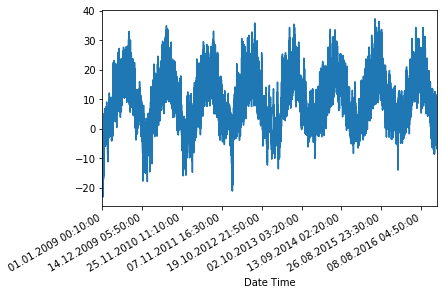

In [7]:
uni_data.plot(subplots=True)

In [8]:
uni_data = uni_data.values

### Normalize futures before training network -> obtenim mitjana i la dividim per la desviació estàndar.

In [9]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [10]:
univariate_past_history = 1000
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]
 [-2.09492208]
 [-2.10997409]
 [-2.11692118]
 [-2.13776242]
 [-2.16786644]
 [-2.16902429]
 [-2.15165658]
 [-2.16555075]
 [-2.1840763 ]
 [-2.18870768]
 [-2.18986553]
 [-2.21533816]
 [-2.21649601]
 [-2.17018213]
 [-2.18870768]
 [-2.17944491]
 [-2.12849964]
 [-2.10071132]
 [-2.11576333]
 [-2.16091936]
 [-2.13081534]
 [-2.07755438]
 [-2.05902883]
 [-2.04166113]
 [-2.03008266]
 [-2.01039926]
 [-2.00692572]
 [-2.01155711]
 [-2.00229433]
 [-1.98955802]
 [-1.96524323]
 [-1.94555983]
 [-1.95598046]
 [-1.96176969]
 [-1.94440199]
 [-1.91314012]
 [-1.89693026]
 [-1.88187825]
 [-1.88419395]
 [-1.8830361 ]
 [-1.89693026]
 [-1.90966658]
 [-1.91892935]
 [-1.92008

In [12]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [13]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

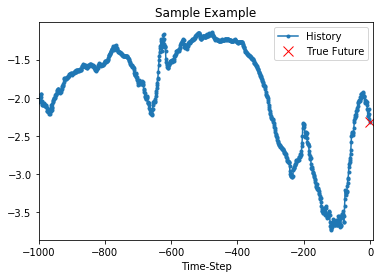

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [15]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

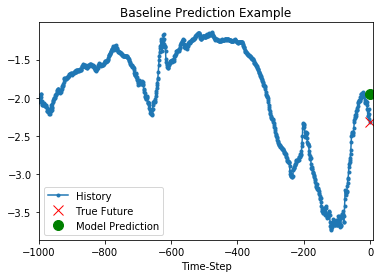

In [16]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [17]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [18]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [19]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [20]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_T_history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=100)

Train for 200 steps, validate for 100 steps
Epoch 1/10
200/200 [==============================] - 72s 358ms/step - loss: 0.3765 - val_loss: 0.1018
Epoch 2/10
200/200 [==============================] - 66s 331ms/step - loss: 0.0973 - val_loss: 0.0344
Epoch 3/10
200/200 [==============================] - 66s 328ms/step - loss: 0.0498 - val_loss: 0.0282
Epoch 4/10
200/200 [==============================] - 68s 338ms/step - loss: 0.0427 - val_loss: 0.0242
Epoch 5/10
200/200 [==============================] - 67s 334ms/step - loss: 0.0288 - val_loss: 0.0224
Epoch 6/10
200/200 [==============================] - 66s 330ms/step - loss: 0.0298 - val_loss: 0.0206
Epoch 7/10
200/200 [==============================] - 65s 325ms/step - loss: 0.0268 - val_loss: 0.0190
Epoch 8/10
200/200 [==============================] - 65s 324ms/step - loss: 0.0251 - val_loss: 0.0178
Epoch 9/10
200/200 [==============================] - 65s 323ms/step - loss: 0.0245 - val_loss: 0.0171
Epoch 10/10
200/200 [========

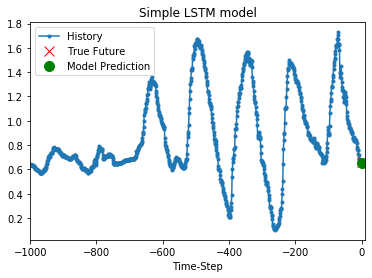

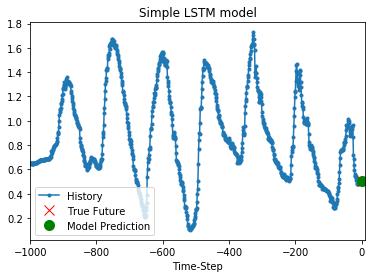

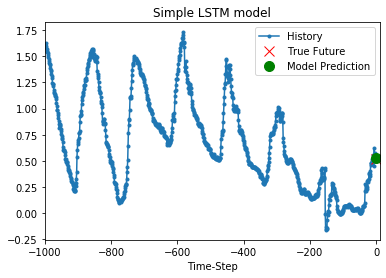

In [21]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()


In [22]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

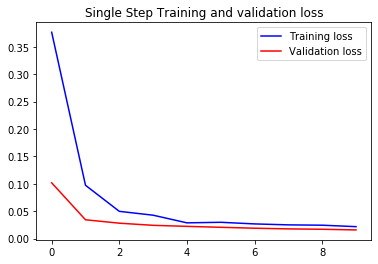

In [23]:
plot_train_history(single_T_history,
                   'Single Step Training and validation loss')

In [50]:
model_json = simple_lstm_model.to_json()

In [51]:
model_json

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "batch_input_shape": [null, 1000, 1], "dtype": "float32", "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 8, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 2}}, {"class_name": "Dense", "config": {"name": "dense", "trainab

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import import model_from_json

# Forecast a multivariate time series

#### Introduim les dos variables que ens interesen

In [24]:
features_considered = ['T (degC)', 'rh (%)']

In [25]:
features_considered

['T (degC)', 'rh (%)']

In [26]:
features = df[features_considered]

In [27]:
features.index=df['T (degC)']

In [28]:
features.head()

,T (degC),rh (%)
T (degC),,
-8.02,-8.02,93.3
-8.41,-8.41,93.4
-8.51,-8.51,93.9
-8.31,-8.31,94.2
-8.27,-8.27,94.1


In [29]:
#features.plot(subplots=True)

#### Normalitzem el dataset utilitzant la mitjana i la desviació estàndar.

In [30]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [31]:
dataset = (dataset-data_mean)/data_std

## Single step -> apren a predir un sol punt en el futur basat en alguna historia previa aportada

In [32]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

##### In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [33]:
past_history = 4000
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [34]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (667, 2)


In [35]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [36]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [37]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [38]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=200)

Train for 200 steps, validate for 200 steps
Epoch 1/10
200/200 [==============================] - 98s 492ms/step - loss: 0.5541 - val_loss: 0.5618
Epoch 2/10
200/200 [==============================] - 97s 483ms/step - loss: 0.5113 - val_loss: 0.5429
Epoch 3/10
200/200 [==============================] - 93s 467ms/step - loss: 0.5265 - val_loss: 0.5634
Epoch 4/10
200/200 [==============================] - 104s 522ms/step - loss: 0.5126 - val_loss: 0.5315
Epoch 5/10
200/200 [==============================] - 96s 478ms/step - loss: 0.4879 - val_loss: 0.5291
Epoch 6/10
200/200 [==============================] - 94s 468ms/step - loss: 0.5333 - val_loss: 0.5572
Epoch 7/10
200/200 [==============================] - 101s 503ms/step - loss: 0.4852 - val_loss: 0.5361
Epoch 8/10
200/200 [==============================] - 105s 523ms/step - loss: 0.4816 - val_loss: 0.5330
Epoch 9/10
200/200 [==============================] - 106s 530ms/step - loss: 0.5014 - val_loss: 0.5195
Epoch 10/10
200/200 [====

In [39]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

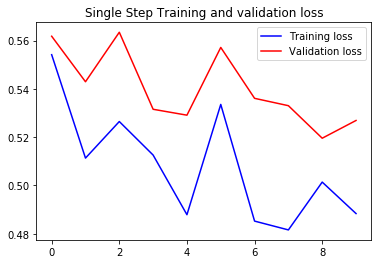

In [40]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

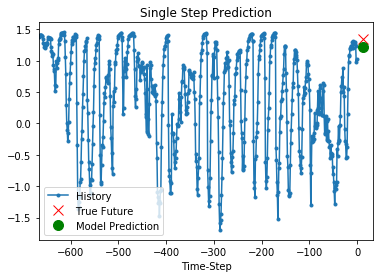

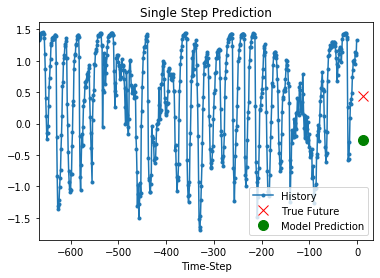

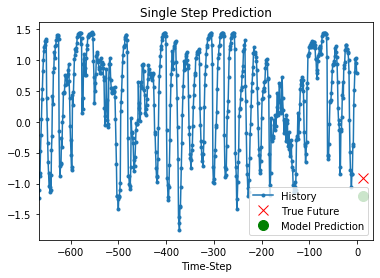

In [41]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

## Multi-step -> apren a predir un sol punt en el futur basat en alguna historia previa aportada

### Unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

#### For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.



In [42]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [43]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (667, 2)

 Target temperature to predict : (72,)


In [44]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [45]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

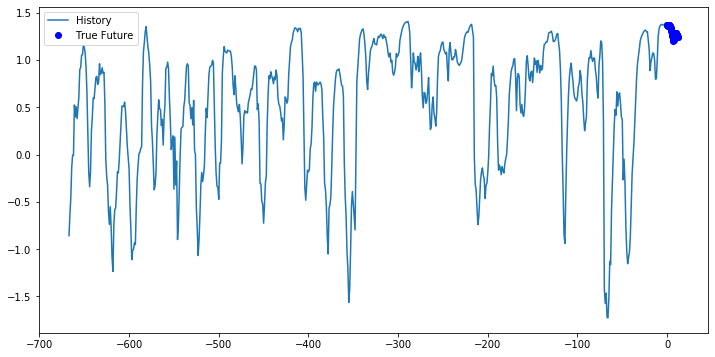

In [46]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [47]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [48]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(256, 72)


In [49]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 146s 731ms/step - loss: nan - val_loss: nan
Epoch 2/10
200/200 [==============================] - 135s 674ms/step - loss: nan - val_loss: nan
Epoch 3/10
200/200 [==============================] - 138s 688ms/step - loss: nan - val_loss: nan
Epoch 4/10
182/200 [==========================>...] - ETA: 11s - loss: nan

KeyboardInterrupt: 

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])